[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

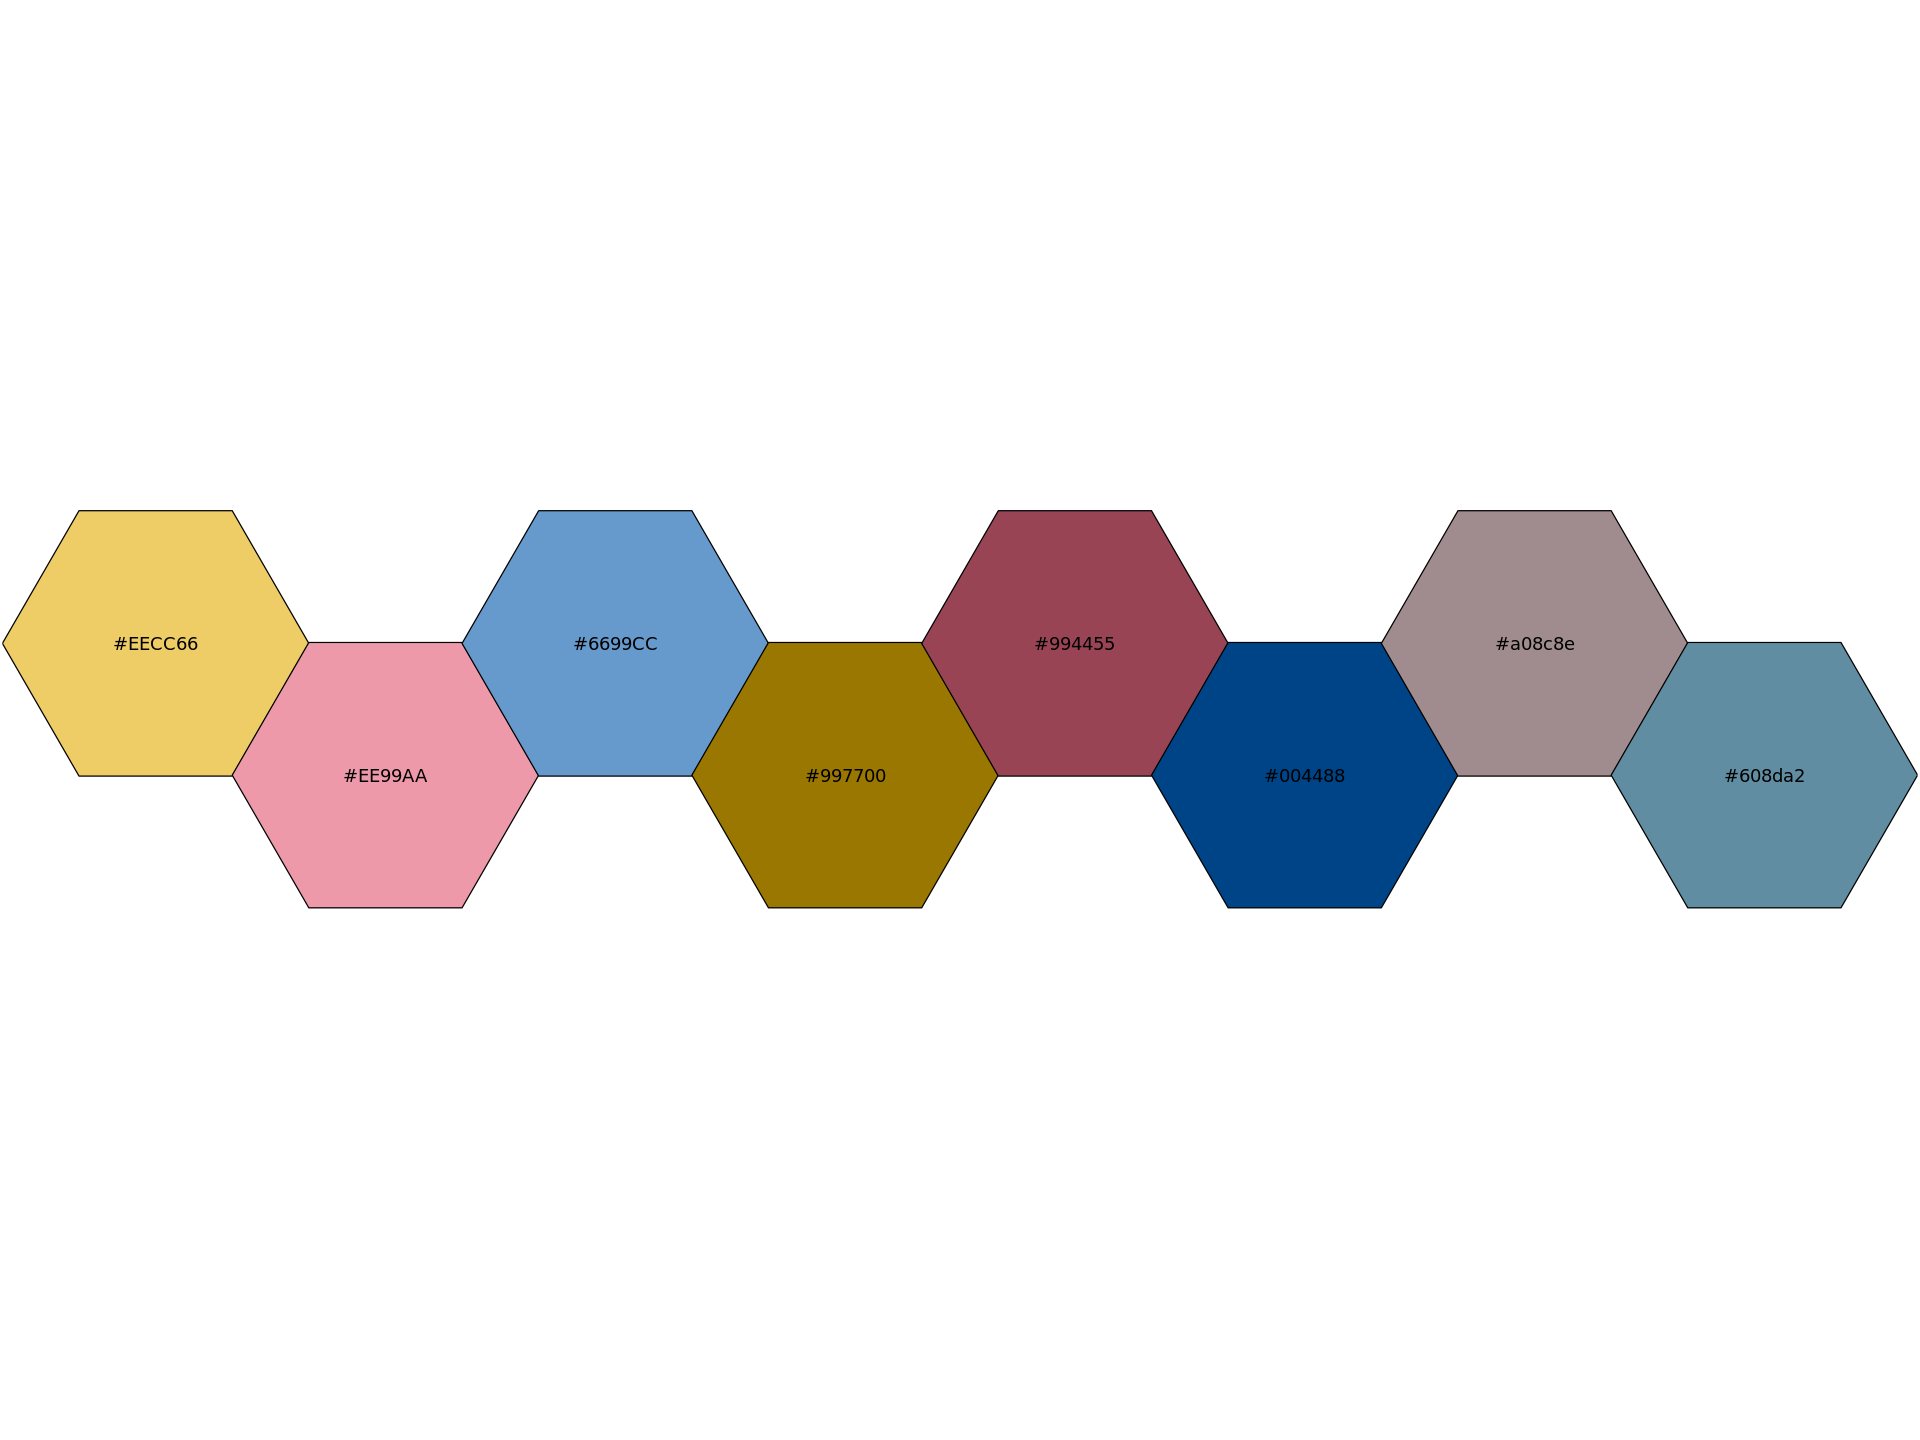

In [11]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [12]:
lst_perc_root <- readRDS(paste0(INT_ReSeq, "lst_perc_root.Rdata"))
lst_perc_Asp <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp.Rdata"))
lst_perc_Asp_species <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp_species.Rdata"))
lst_perc_Asp_species_maxFP <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp_species_maxFP.Rdata"))
lst_perc_Asp_species_sumFP <- readRDS(paste0(INT_ReSeq, "lst_perc_Asp_species_sumFP.Rdata"))

lst_cnt_Fungi <- readRDS(paste0(INT_ReSeq, "lst_cnt_Fungi.Rdata"))
lst_cnt_Asp <- readRDS(paste0(INT_ReSeq, "lst_cnt_Asp.Rdata"))
lst_cnt_Asp_species <- readRDS(paste0(INT_ReSeq, "lst_cnt_Asp_species.Rdata"))

classification_table <- as.matrix(read.csv(paste0(INT_ReSeq, "classification_table.csv"), header = TRUE, row.names = 1))

mt_nr_genomes <- readRDS(paste0(INT_database_stats, "mt_nr_genomes.Rdata"))
mt_inspect <- readRDS(paste0(INT_database_stats, "mt_inspect.Rdata"))

In [13]:
temp <- c('RS','EPRSFv46','EPRSFv46DM','EPRSc2','EPRSFv46MCAspDM','EPRSFv64','EPRSFv64DM','EPRSFv64MCAspDM')

In [14]:
Aspergillus_prct <- list()
for (i in 1:4){
    if(exists("Aspergillus_prct_tbl")){rm("Aspergillus_prct_tbl")}
    for(c in names(lst_perc_Asp)){
        lst_perc_tmp <- list(lst_perc_Asp[[c]], lst_perc_Asp_species[[c]], 
                             lst_perc_Asp_species_sumFP[[c]], lst_perc_root[[c]])[i]
        Aspergillus_prct_add <-  melt(lst_perc_tmp, value.name = "percentage", varnames = c("db", "strain")) %>% 
            #filter(grepl(strain, pattern = "Aspergillus") | grepl(strain, pattern = "Penicillium")) %>% 
            filter(db %in% temp)  %>%
            mutate(db = fct_relevel(db, temp))  %>%  
            mutate(strain = gsub(strain, pattern = "sample[1-9]", replacement = "")) %>% 
            mutate(strain = gsub(strain, pattern = "Syn[1-9]", replacement = "")) %>% 
            mutate(strain = gsub(strain, pattern = "\\.", replacement = " "))  %>% 
            mutate(strain = gsub(strain, pattern = "Aspergillus", replacement = "Aspergillus "))  %>% 
            mutate(strain = gsub(strain, pattern = "Penicillium", replacement = "Penicillium "))  %>% 
            mutate(strain = gsub(strain, pattern = "Fusarium", replacement = "Fusarium "))  %>% 
            mutate(strain = gsub(strain, pattern = "Botrytis", replacement = "Botrytis "))  %>% 
            mutate(strain = gsub(strain, pattern = "Komagataella", replacement = "Komagataella "))  %>% 
            mutate(strain = gsub(strain, pattern = "Pneumocystis", replacement = "Pneumocystis "))  %>% 
            mutate(strain = gsub(strain, pattern = "Rhizopus", replacement = "Rhizopus "))  %>% 
            mutate(species = gsub(strain, pattern = "(?<=[a-z])([A-Z]).*", replacement = "", perl = TRUE))  %>% 
            mutate(genus = ifelse(grepl(strain, pattern = "Aspergillus"), yes = "Aspergillus", no = 
                           ifelse(grepl(strain, pattern = "Penicillium"), yes = "Penicillium", no = "Others"))) %>% 
            mutate(genus = factor(genus, levels = c("Aspergillus", "Penicillium", "Others"))) %>% 
            mutate(species = gsub(species, pattern = "costaricaensis", replacement = "costaricensis")) %>% 
            mutate(strain = gsub(strain, pattern = "(?<=[a-z])([A-Z])", replacement = " ", perl = TRUE))  %>% 
            mutate(species_in_db = "no") %>% 
            mutate(cnf = c)

        for (db in dbs_minT2T){
            if (db == "EPRS"){db_nm <- "EPRS_miss2gen"} else {db_nm = db}

            in_db_insp <- paste0(DB_DIR, db_nm, "_inspect.txt")
            db_insp <- read.csv(file = in_db_insp, header=FALSE, sep = "\t", stringsAsFactors=FALSE)
            db_insp$V6 <-  str_trim(db_insp$V6, side = "left")    
            Aspergillus_prct_add$species_in_db[which(Aspergillus_prct_add$species %in% db_insp$V6 & 
                                                     Aspergillus_prct_add$db == db)] <- "yes"
        }
        if(exists("Aspergillus_prct_tbl")){Aspergillus_prct_tbl <- rbind(Aspergillus_prct_tbl, Aspergillus_prct_add)}
        else {Aspergillus_prct_tbl <- Aspergillus_prct_add}
    }
    Aspergillus_prct[[i]] <- Aspergillus_prct_tbl 
}

In [15]:
options(repr.plot.width=16, repr.plot.height=12)
lbls = c("Apergillus genus", "correct Aspergillus species",
         "sum incorrect Aspergillus species", "Classified (any taxa)")
plt_DB_extension_m <- list()
for (i in 1:4){
    plt_DB_extension_m[[i]] <- Aspergillus_prct[[i]] %>% 
        filter(grepl(strain, pattern = "Aspergillus")) %>%
        mutate(conf= gsub(cnf, pattern = "conf", replacement = "")) %>% 
        group_by(conf,db) %>%  
        summarise(mean = mean(percentage, na.rm = TRUE), .groups = "keep")  %>% 
        mutate(EuPathDB_version = gsub("\\D", "", x = db))  %>% 
        mutate(EuPathDB_version = ifelse(db == "RS w/o CHM13v2", yes = "none", no = EuPathDB_version))  %>% 
        mutate(EuPathDB_version = ifelse(db %in% c("EPRS", "EPRSc2"), yes = "46", no = EuPathDB_version)) %>%
        mutate(EuPathDB_version = ifelse(EuPathDB_version == "", yes = "none", no = EuPathDB_version)) %>% 
        mutate(EuPathDB_version = ifelse(grepl(db, pattern = "MC"), 
                                           yes = paste0(EuPathDB_version, " + MycoCosm"), no = EuPathDB_version)) %>% 
        filter(EuPathDB_version != "none" & !grepl(EuPathDB_version, pattern = "MycoCosm") ) %>% 
        mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
        mutate(db = ifelse(db == "EPRSFv46", yes = "uRE.21", no = as.character(db))) %>% 
        mutate(db = ifelse(db == "EPRSFv46DM", yes = "dRE.21", no = as.character(db))) %>%  
        mutate(db = ifelse(db == "EPRSFv64", yes = "uRE.31", no = as.character(db))) %>% 
        mutate(db = ifelse(db == "EPRSFv64DM", yes = "dRE.31", no = as.character(db))) %>% 
        ggplot(aes(x = conf, y = mean, group = db, col = db)) + 
            geom_line(aes(linetype = db), linewidth = 1) + ggtitle(lbls[i]) + theme_bw() + 
            xlab("Confidence Threshold") + ylab("Mean % reads") + 
            scale_linetype_manual(values = c("twodash", "dotted", "dotted", "solid", "solid")) +
            scale_color_manual(values = c(colors_mc[2], colors_mc[2], colors_mc[3], colors_mc[2], colors_mc[3])) + 
            labs(color = "database", linetype = "database")
}

In [16]:
options(repr.plot.width=7, repr.plot.height=4)
lbls = c("Apergillus genus", "correct Aspergillus species",
         "sum incorrect Aspergillus species", "Classified (any taxa)")

plt_DB_extension_cnfThr = data_DB_extension_cnfThr <- list()
for (i in 1:4){
    data_DB_extension_cnfThr[[i]] <- Aspergillus_prct[[i]] %>% 
        filter(grepl(strain, pattern = "Aspergillus")) %>%
        mutate(conf= gsub(cnf, pattern = "conf", replacement = "")) %>% 
        group_by(conf) %>% 
        t_test(percentage ~ db, paired = TRUE, p.adjust.method="bonferroni", 
              var.equal="strain", alternative= "greater"
              ) %>% 
        filter(grepl(group1, pattern = "EPRSFv46") & grepl(group2, pattern = "EPRSFv46DM")|
               grepl(group1, pattern = "EPRSFv64") & grepl(group2, pattern = "EPRSFv64DM")|
               grepl(group1, pattern = "EPRSFv46DM") & grepl(group2, pattern = "EPRSc2")|
               grepl(group1, pattern = "EPRSFv46") & grepl(group2, pattern = "EPRSc2")) %>% 
        mutate(FungiDB_version = ifelse(grepl(group1, pattern = "v46"), yes = "46", no = 
                                         ifelse(grepl(group1, pattern = "v64"), yes = "64", no = NA))) %>% 
        mutate(label = paste0(group1, " >> ", group2)) %>% 
        mutate(label = factor(label, levels = c("EPRSFv46 >> EPRSFv46DM", 
                                        "EPRSFv64 >> EPRSFv64DM", 
                                        "EPRSFv46DM >> EPRSc2", 
                                        "EPRSFv46 >> EPRSc2"))) %>% 
        mutate(Cleanup = ifelse(label %in% c("EPRSFv46 >> EPRSFv46DM","EPRSFv64 >> EPRSFv64DM"), 
                                            yes = "dustmasking", 
                         ifelse(label %in% c("EPRSFv46DM >> EPRSc2"), 
                                            yes = "decontamination", no = "dustmasking + decontamination"))) %>% 
        mutate(Cleanup = factor(Cleanup, levels = c("dustmasking", "decontamination", 
                                                    "dustmasking + decontamination"))) %>% 
        mutate(processing = paste0(Cleanup, " of v", FungiDB_version)) %>% 
        mutate(processing = factor(processing, levels = c("dustmasking of v46", "dustmasking of v64", 
                                                    "dustmasking + decontamination of v46"))) 
    
    plt_DB_extension_cnfThr[[i]] <- data_DB_extension_cnfThr[[i]] %>% 
        filter(Cleanup != "decontamination") %>% 
        ggplot(aes(x = conf, y = p.adj, group = label, col = processing)) +
            geom_line(aes(linetype = processing), linewidth = 1) + 
            geom_hline(yintercept = 0.001, linetype = 1, color = "darkgrey", linewidth = 1) +  
            scale_y_continuous(trans='log10') + ggtitle(lbls[i]) + 
            xlab("Confidence Threshold") + ylab("p-value\nlog10") +  
            scale_linetype_manual(values = c("dashed", "dashed", "twodash")) + 
            scale_color_manual(values = c(colors_mc[2], colors_mc[3], colors_mc[2])) + 
            theme(text = element_text(size = 12)) 
}

In [17]:
data_DB_extension_cnfThr[[3]] %>% 
    filter(conf == "0.8")

conf,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif,FungiDB_version,label,Cleanup,processing
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<fct>
0.8,percentage,EPRSFv46,EPRSFv46DM,55,55,1.592772,54,0.059,1.000,ns,46,EPRSFv46 >> EPRSFv46DM,dustmasking,dustmasking of v46
0.8,percentage,EPRSFv46,EPRSc2,55,55,1.732333,54,0.044,1.000,ns,46,EPRSFv46 >> EPRSc2,dustmasking + decontamination,dustmasking + decontamination of v46
0.8,percentage,EPRSFv46DM,EPRSc2,55,55,2.112554,54,0.020,0.549,ns,46,EPRSFv46DM >> EPRSc2,decontamination,NA
0.8,percentage,EPRSFv64,EPRSFv64DM,55,55,1.922606,54,0.030,0.837,ns,64,EPRSFv64 >> EPRSFv64DM,dustmasking,dustmasking of v64


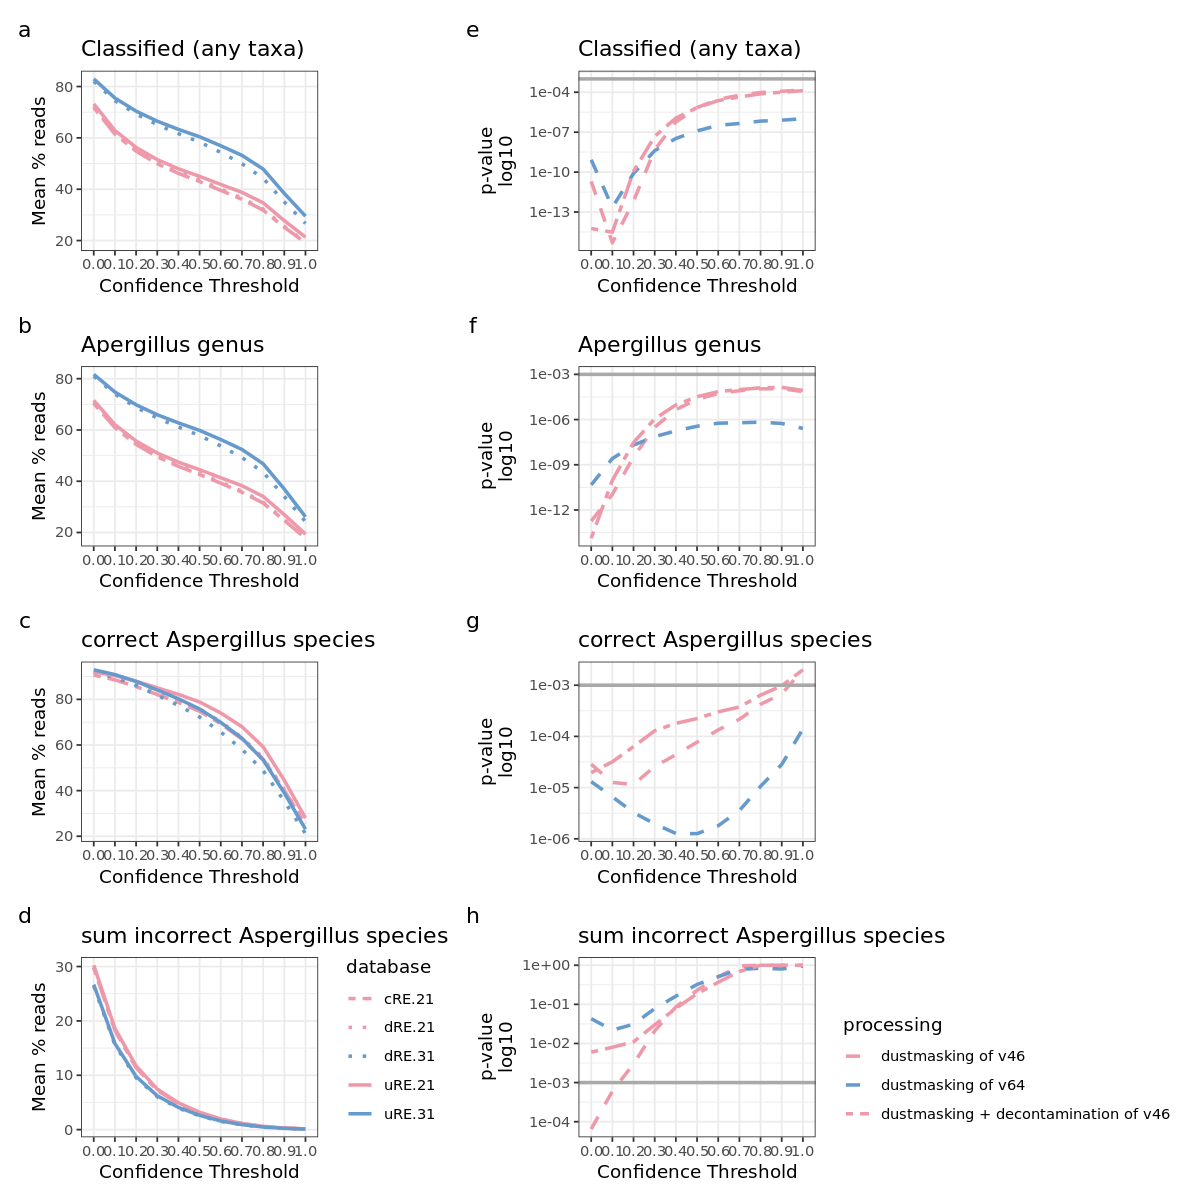

In [18]:
options(repr.plot.width=10, repr.plot.height=10)
layout= "
    AE
    BF
    CG
    DH"

SuplFig5 <- 
    (plt_DB_extension_m[[4]] + labs(tag = 'a') + guides(linetype = "none", color = "none")) + 
    (plt_DB_extension_m[[1]] + labs(tag = 'b') + guides(linetype = "none", color = "none")) + 
    (plt_DB_extension_m[[2]] + labs(tag = 'c') + guides(linetype = "none", color = "none")) + 
    (plt_DB_extension_m[[3]] + labs(tag = 'd')) + 
    (plt_DB_extension_cnfThr[[4]] + labs(tag = 'e') + guides(linetype = "none", color = "none") + theme_bw()) +
    (plt_DB_extension_cnfThr[[1]] + labs(tag = 'f') + guides(linetype = "none", color = "none") + theme_bw()) +
    (plt_DB_extension_cnfThr[[2]] + labs(tag = 'g') + guides(linetype = "none", color = "none") + theme_bw()) +
    (plt_DB_extension_cnfThr[[3]] + labs(tag = 'h')) + 
         plot_layout(design = layout) &
            theme_bw() &
            theme(legend.position="right", legend.direction = "vertical", legend.justification='bottom')

SuplFig5

ggsave("../../output/suppl_figures/SuplFig5_R.png", 
       SuplFig5, width = 10, height = 10)
ggsave("../../output/suppl_figures/SuplFig5_R.pdf", 
       SuplFig5, width = 10, height = 10)

In [19]:
data_DB_extension_cnfThr[[3]] %>% 
    filter(conf == "0.0") %>% 
    filter(group1 == "EPRSFv46" & group2 == "EPRSFv46DM")

conf,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif,FungiDB_version,label,Cleanup,processing
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<fct>
0.0,percentage,EPRSFv46,EPRSFv46DM,55,55,5.09261,54,2.31e-06,6.47e-05,****,46,EPRSFv46 >> EPRSFv46DM,dustmasking,dustmasking of v46


In [41]:
for (i in 1:4){
    lst_perc_tmp <- list(lst_perc_Asp[[c]], lst_perc_Asp_species[[c]], 
                             lst_perc_Asp_species_sumFP[[c]], lst_perc_root[[c]])[i]
    Aspergillus_prct_add <-  melt(lst_perc_tmp, value.name = "percentage", varnames = c("db", "strain"))
    test <- Aspergillus_prct[[i]] %>% 
            filter(grepl(strain, pattern = "Aspergillus")) %>%
            mutate(conf= gsub(cnf, pattern = "conf", replacement = "")) %>% 
            group_by(conf,db) %>%  
            summarise(mean = mean(percentage, na.rm = TRUE), .groups = "keep")  %>% 
            mutate(EuPathDB_version = gsub("\\D", "", x = db))  %>% 
            mutate(EuPathDB_version = ifelse(db == "RS w/o CHM13v2", yes = "none", no = EuPathDB_version))  %>% 
            mutate(EuPathDB_version = ifelse(db %in% c("EPRS", "EPRSc2"), yes = "46", no = EuPathDB_version)) %>%
            mutate(EuPathDB_version = ifelse(EuPathDB_version == "", yes = "none", no = EuPathDB_version)) %>% 
            mutate(EuPathDB_version = ifelse(grepl(db, pattern = "MC"), 
                                               yes = paste0(EuPathDB_version, " + MycoCosm"), no = EuPathDB_version)) %>% 
            filter(EuPathDB_version != "none" & !grepl(EuPathDB_version, pattern = "MycoCosm") ) %>% 
            mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46", yes = "uRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46DM", yes = "dRE.21", no = as.character(db))) %>%  
            mutate(db = ifelse(db == "EPRSFv64", yes = "uRE.31", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv64DM", yes = "dRE.31", no = as.character(db))) %>% 
            filter(conf == "0.8") %>% 
            filter(grepl(db, pattern = 21))

    print(round(1-test$mean/test$mean[1], digits = 2)*100)

    test <- Aspergillus_prct[[i]] %>% 
            filter(grepl(strain, pattern = "Aspergillus")) %>%
            mutate(conf= gsub(cnf, pattern = "conf", replacement = "")) %>% 
            group_by(conf,db) %>%  
            summarise(mean = mean(percentage, na.rm = TRUE), .groups = "keep")  %>% 
            mutate(EuPathDB_version = gsub("\\D", "", x = db))  %>% 
            mutate(EuPathDB_version = ifelse(db == "RS w/o CHM13v2", yes = "none", no = EuPathDB_version))  %>% 
            mutate(EuPathDB_version = ifelse(db %in% c("EPRS", "EPRSc2"), yes = "46", no = EuPathDB_version)) %>%
            mutate(EuPathDB_version = ifelse(EuPathDB_version == "", yes = "none", no = EuPathDB_version)) %>% 
            mutate(EuPathDB_version = ifelse(grepl(db, pattern = "MC"), 
                                               yes = paste0(EuPathDB_version, " + MycoCosm"), no = EuPathDB_version)) %>% 
            filter(EuPathDB_version != "none" & !grepl(EuPathDB_version, pattern = "MycoCosm") ) %>% 
            mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46", yes = "uRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46DM", yes = "dRE.21", no = as.character(db))) %>%  
            mutate(db = ifelse(db == "EPRSFv64", yes = "uRE.31", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv64DM", yes = "dRE.31", no = as.character(db))) %>% 
            filter(conf == "0.8") %>% 
            filter(grepl(db, pattern = 31))

    print(round(1-test$mean/test$mean[1], digits = 2)*100)
}

[1] 0 7 8
[1] 0 7
[1] 0 8 9
[1] 0 9
[1] 0 3 3
[1] 0 4
[1] 0 7 8
[1] 0 7


In [58]:
for (i in 3){
    lst_perc_tmp <- list(lst_perc_Asp[[c]], lst_perc_Asp_species[[c]], 
                             lst_perc_Asp_species_sumFP[[c]], lst_perc_root[[c]])[i]
    Aspergillus_prct_add <-  melt(lst_perc_tmp, value.name = "percentage", varnames = c("db", "strain"))
    test.21 <- Aspergillus_prct[[i]] %>% 
            filter(grepl(strain, pattern = "Aspergillus")) %>%
            mutate(conf= gsub(cnf, pattern = "conf", replacement = "")) %>% 
            group_by(conf,db) %>%  
            summarise(mean = mean(percentage, na.rm = TRUE), .groups = "keep")  %>% 
            mutate(EuPathDB_version = gsub("\\D", "", x = db))  %>% 
            mutate(EuPathDB_version = ifelse(db == "RS w/o CHM13v2", yes = "none", no = EuPathDB_version))  %>% 
            mutate(EuPathDB_version = ifelse(db %in% c("EPRS", "EPRSc2"), yes = "46", no = EuPathDB_version)) %>%
            mutate(EuPathDB_version = ifelse(EuPathDB_version == "", yes = "none", no = EuPathDB_version)) %>% 
            mutate(EuPathDB_version = ifelse(grepl(db, pattern = "MC"), 
                                               yes = paste0(EuPathDB_version, " + MycoCosm"), no = EuPathDB_version)) %>% 
            filter(EuPathDB_version != "none" & !grepl(EuPathDB_version, pattern = "MycoCosm") ) %>% 
            mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46", yes = "uRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46DM", yes = "dRE.21", no = as.character(db))) %>%  
            mutate(db = ifelse(db == "EPRSFv64", yes = "uRE.31", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv64DM", yes = "dRE.31", no = as.character(db))) %>% 
            filter(conf == "0.1") %>% 
            filter(grepl(db, pattern = 21))

    test.31 <- Aspergillus_prct[[i]] %>% 
            filter(grepl(strain, pattern = "Aspergillus")) %>%
            mutate(conf= gsub(cnf, pattern = "conf", replacement = "")) %>% 
            group_by(conf,db) %>%  
            summarise(mean = mean(percentage, na.rm = TRUE), .groups = "keep")  %>% 
            mutate(EuPathDB_version = gsub("\\D", "", x = db))  %>% 
            mutate(EuPathDB_version = ifelse(db == "RS w/o CHM13v2", yes = "none", no = EuPathDB_version))  %>% 
            mutate(EuPathDB_version = ifelse(db %in% c("EPRS", "EPRSc2"), yes = "46", no = EuPathDB_version)) %>%
            mutate(EuPathDB_version = ifelse(EuPathDB_version == "", yes = "none", no = EuPathDB_version)) %>% 
            mutate(EuPathDB_version = ifelse(grepl(db, pattern = "MC"), 
                                               yes = paste0(EuPathDB_version, " + MycoCosm"), no = EuPathDB_version)) %>% 
            filter(EuPathDB_version != "none" & !grepl(EuPathDB_version, pattern = "MycoCosm") ) %>% 
            mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46", yes = "uRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv46DM", yes = "dRE.21", no = as.character(db))) %>%  
            mutate(db = ifelse(db == "EPRSFv64", yes = "uRE.31", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv64DM", yes = "dRE.31", no = as.character(db))) %>% 
            filter(conf == "0.1") %>% 
            filter(grepl(db, pattern = 31))

    max(round(test.31$mean[2]-test.31$mean[1], digits = 1), round(test.21$mean[c(2,3)]-test.21$mean[1], digits = 1)) %>% print()
    min(round(test.31$mean[2]-test.31$mean[1], digits = 1), round(test.21$mean[c(2,3)]-test.21$mean[1], digits = 1)) %>% print()
}
    

[1] -0.3
[1] -0.4
